## VRP
reference: 
- https://en.wikipedia.org/wiki/Vehicle_routing_problem
- https://www.zhihu.com/question/275293660

![image](Figure_illustrating_the_vehicle_routing_problem.png)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def generate_data():
    size = 10
    X = np.random.random(size)
    Y = np.random.random(size)

    plt.figure('data')
    plt.scatter(X,Y,alpha=0.25)
    plt.show()

    data = pd.DataFrame({'X':X, 'Y':Y})
    data.index.name = 'id'
    data.head()
    data.to_csv('data/coordnates.csv')

generate_data()

<Figure size 640x480 with 1 Axes>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
coordinates = pd.read_csv('data/coordnates.csv')
coordinates = {str(int(_id)):(x,y) for _id, x, y in coordinates[['id', 'X', 'Y']].values}
coordinates

{'0': (0.1664646683978377, 0.4794948642842665),
 '1': (0.6480712651188881, 0.3465039881910501),
 '2': (0.3917914557935077, 0.4381549796359445),
 '3': (0.481162229906945, 0.4334612798838712),
 '4': (0.6445258982757863, 0.6196696331773636),
 '5': (0.6866070091688393, 0.8438814223076123),
 '6': (0.7771593651742288, 0.6614673572006546),
 '7': (0.07959878561818345, 0.5396423418416599),
 '8': (0.5790996084750809, 0.7324588770181835),
 '9': (0.27425569295754704, 0.7673917025363242)}

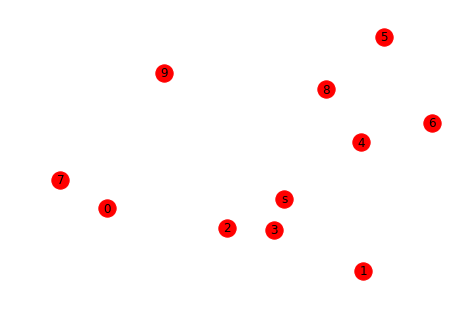

In [3]:
import networkx as nx
coordinates['s'] = (0.5, 0.5)
graph = nx.Graph()
graph.add_nodes_from(coordinates.keys())
nx.draw(graph, coordinates, with_labels=True)

In [4]:
from functools import lru_cache
from math import sqrt
import debug_tools
import time

#p2p refers to point to point
# @lru_cache(15*15)
# @debug_tools.debug_print
def get_p2p_distance(point1:str, point2:str):
    global coordinates
    x1, y1 = coordinates[point1]
    x2, y2 = coordinates[point2]
    return sqrt((x1-x2)**2 + (y1-y2)**2)

# p2s refers to point to shape
# @debug_tools.debug_print
def get_p2s_distance(point:str, trace:list):
    # trace is a list of edges
    # edge = (point1, point2)
    
    # 到一个edge的两个点距离之和最小
    closest_edge = min(trace, key = lambda e:get_p2p_distance(point, e[0]) * get_p2p_distance(point, e[1])) 
    # 如果把<a,b> 替换成 <a,c>, <c,d> 路程会增加多少
    distance_increase = get_p2p_distance(closest_edge[0], point) + get_p2p_distance(closest_edge[1], point) - get_p2p_distance(*closest_edge) 
    return distance_increase, closest_edge, point

# @debug_tools.debug_print
def visulize_trace(trace):
    global coordinates
    edges = {s:[e] for s, e in trace}
    graph = nx.DiGraph(edges)
    graph.add_nodes_from(coordinates.keys())
    nx.draw(graph, coordinates, with_labels=True)
    plt.show()

## TSP Dynamic Programming solution

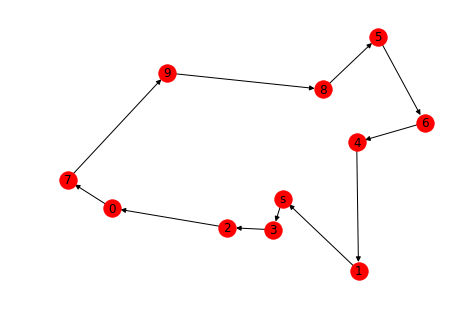

[('s', '3'),
 ('3', '2'),
 ('2', '0'),
 ('0', '7'),
 ('7', '9'),
 ('9', '8'),
 ('8', '5'),
 ('5', '6'),
 ('6', '4'),
 ('4', '1'),
 ('1', 's')]

In [5]:
class route:
#     @debug_tools.debug_print
    def __init__(self, trace):
        global coordinates
        self.trace  = trace # a list of tuple (edges)
        self.length = sum([get_p2p_distance(*e) for e in trace])
    
    def add(self, node):
        end_of_trace = self.trace[-1][-1]
        new_route = route([])
        new_route.trace = self.trace  + [(end_of_trace, node)]
        new_route.length = self.length + get_p2p_distance(end_of_trace, node)
        return new_route

debug_tools.stack_level = 0

@lru_cache(maxsize=10**10)
def opt_route(need_visited, end):
    # need_visited is a set of node
    if len(need_visited) == 1:
        return route([('s', end)])
    else:
        S = tuple([n for n in need_visited if n!=end])
        routes = [opt_route(S, n).add(end) for n in S]
        return min(routes, key=lambda r: r.length)


need_visited = tuple([e for e in coordinates.keys() if e != 's'])
best_route = opt_route(need_visited,'s')
visulize_trace(best_route.trace)
best_route.trace